In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import random

import matplotlib.pyplot as plt
%matplotlib inline

# Set some parameters to get good visuals - style to ggplot and size to 15,10
plt.style.use('ggplot')
import matplotlib.style as style
style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 8)

import seaborn as sns
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

from sklearn import preprocessing
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [2]:
data = pd.read_csv('final_ip_mapped_data.csv')
#data=data.iloc[:10000]
#data

# Feature Building

In [3]:
data['@timestamp'] = pd.to_datetime(data['@timestamp'])
#data['@timestamp']

In [4]:
data.sort_values(['ip_address', '@timestamp'], inplace=True)

In [5]:
data['shift_time'] = data.groupby(['ip_address'])['@timestamp'].shift(1)

In [6]:
data['time_diff'] = (data['@timestamp'] - data['shift_time']).dt.seconds//60

In [7]:
data['date'] = data['@timestamp'].dt.date

In [8]:
data['dow'] = data['@timestamp'].dt.weekday

In [9]:
data['hour'] = data['@timestamp'].dt.hour

In [10]:
data['is_weekend'] = ((data['dow']==5)|(data['dow']==6)).astype(int)

In [11]:
data['hour_bucket'] = data['hour']//4

In [12]:
data.head(10)

,@timestamp,_id,ip_address,shift_time,time_diff,date,dow,hour,is_weekend,hour_bucket
721473,2019-06-09 00:06:09,DBuOOWsB7mP0GwVzhZ9U,10.1.1.1,NaT,NaN,2019-06-09,6,0,1,0
720483,2019-06-09 01:28:39,bB7aOWsB7mP0GwVzDY5G,10.1.1.1,2019-06-09 00:06:09,82.0,2019-06-09,6,1,1,0
719233,2019-06-09 03:12:49,R0w5OmsBoTGddM7vayZT,10.1.1.1,2019-06-09 01:28:39,104.0,2019-06-09,6,3,1,0
719222,2019-06-09 03:13:45,U0w6OmsBoTGddM7vRi8R,10.1.1.1,2019-06-09 03:12:49,0.0,2019-06-09,6,3,1,0
718875,2019-06-09 03:42:39,z01UOmsBoTGddM7vuzyC,10.1.1.1,2019-06-09 03:13:45,28.0,2019-06-09,6,3,1,0
718730,2019-06-09 03:54:45,x01fOmsBoTGddM7vz6d3,10.1.1.1,2019-06-09 03:42:39,12.0,2019-06-09,6,3,1,0
718240,2019-06-09 04:35:35,nk-FOmsBoTGddM7vLRjb,10.1.1.1,2019-06-09 03:54:45,40.0,2019-06-09,6,4,1,1
717685,2019-06-09 05:21:49,N1CvOmsBoTGddM7vhbSz,10.1.1.1,2019-06-09 04:35:35,46.0,2019-06-09,6,5,1,1
717521,2019-06-09 05:35:29,tlG8OmsBoTGddM7vCDDU,10.1.1.1,2019-06-09 05:21:49,13.0,2019-06-09,6,5,1,1
717169,2019-06-09 06:04:49,uFLWOmsBoTGddM7v4zfT,10.1.1.1,2019-06-09 05:35:29,29.0,2019-06-09,6,6,1,1


# IP Profile Building

In [13]:
ip_col = 'ip_address'

## Counts

In [14]:
ip_counts = data.groupby(ip_col)['@timestamp'].count().reset_index()
ip_counts

,ip_address,@timestamp
0,10.1.1.1,1446
1,10.1.1.100,2860
2,10.1.1.101,1465
3,10.1.1.106,1408
4,10.1.1.109,1459
...,...,...
381,10.1.2.86,4307
382,10.1.2.89,2826
383,10.1.2.90,2904
384,10.1.2.95,2868


In [93]:
ip_counts = ip_counts.rename(columns={'@timestamp':'total_count'})
ip_counts

,ip_address,total_count
0,10.1.1.1,1446
1,10.1.1.100,2860
2,10.1.1.101,1465
3,10.1.1.106,1408
4,10.1.1.109,1459
...,...,...
381,10.1.2.86,4307
382,10.1.2.89,2826
383,10.1.2.90,2904
384,10.1.2.95,2868


In [225]:
x=ip_counts.sort_values('total_count', ascending=False)
x=x.iloc[:10]
x

,ip_address,total_count
370,10.1.2.63,4372
255,10.1.2.249,4353
177,10.1.1.63,4339
311,10.1.2.386,4326
164,10.1.1.486,4317
381,10.1.2.86,4307
62,10.1.1.249,4301
118,10.1.1.386,4300
188,10.1.1.86,4293
357,10.1.2.486,4251


In [226]:
lst1=x['ip_address'].to_numpy()
lst2=x['total_count'].to_numpy()
lst2

array([4372, 4353, 4339, 4326, 4317, 4307, 4301, 4300, 4293, 4251],
      dtype=int64)

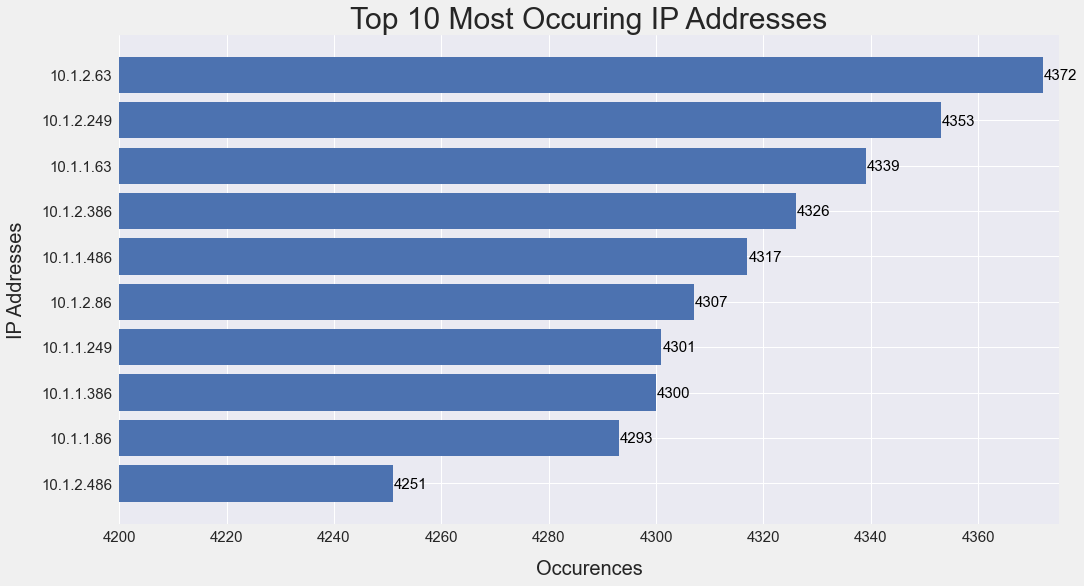

In [228]:
fig, ax = plt.subplots(figsize =(15, 9))
 
# Horizontal Bar Plot
ax.barh(lst1, lst2)
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 15,
             color ='black')

ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)
# Add Plot Title
plt.title('Top 10 Most Occuring IP Addresses', fontdict={'fontsize': 30})
 
# Show Plot
plt.xlabel('Occurences', fontdict={'fontsize': 20}, labelpad=15)
plt.ylabel('IP Addresses', fontdict={'fontsize': 20}, labelpad=15)
plt.xlim([4200, 4375])
plt.show()

## Daily counts average

In [16]:
daily_counts = data.groupby([ip_col, 'date'])['@timestamp'].count().reset_index()

In [17]:
daily_counts = daily_counts.rename(columns={'@timestamp':'daily_counts'})
daily_counts

,ip_address,date,daily_counts
0,10.1.1.1,2019-06-09,36
1,10.1.1.1,2019-06-10,37
2,10.1.1.1,2019-06-11,70
3,10.1.1.1,2019-06-12,38
4,10.1.1.1,2019-06-13,32
...,...,...,...
11575,10.1.2.99,2019-07-04,79
11576,10.1.2.99,2019-07-05,61
11577,10.1.2.99,2019-07-06,89
11578,10.1.2.99,2019-07-07,47


In [18]:
daily_counts_agg = daily_counts.groupby(ip_col).daily_counts.median().reset_index()
daily_counts_agg

,ip_address,daily_counts
0,10.1.1.1,40.0
1,10.1.1.100,78.0
2,10.1.1.101,40.0
3,10.1.1.106,35.5
4,10.1.1.109,42.5
...,...,...
381,10.1.2.86,111.0
382,10.1.2.89,73.5
383,10.1.2.90,76.0
384,10.1.2.95,77.5


In [19]:
daily_counts_agg.head(20)

,ip_address,daily_counts
0,10.1.1.1,40.0
1,10.1.1.100,78.0
2,10.1.1.101,40.0
3,10.1.1.106,35.5
4,10.1.1.109,42.5
5,10.1.1.110,41.0
6,10.1.1.114,37.0
7,10.1.1.118,42.0
8,10.1.1.119,42.0
9,10.1.1.12,40.0


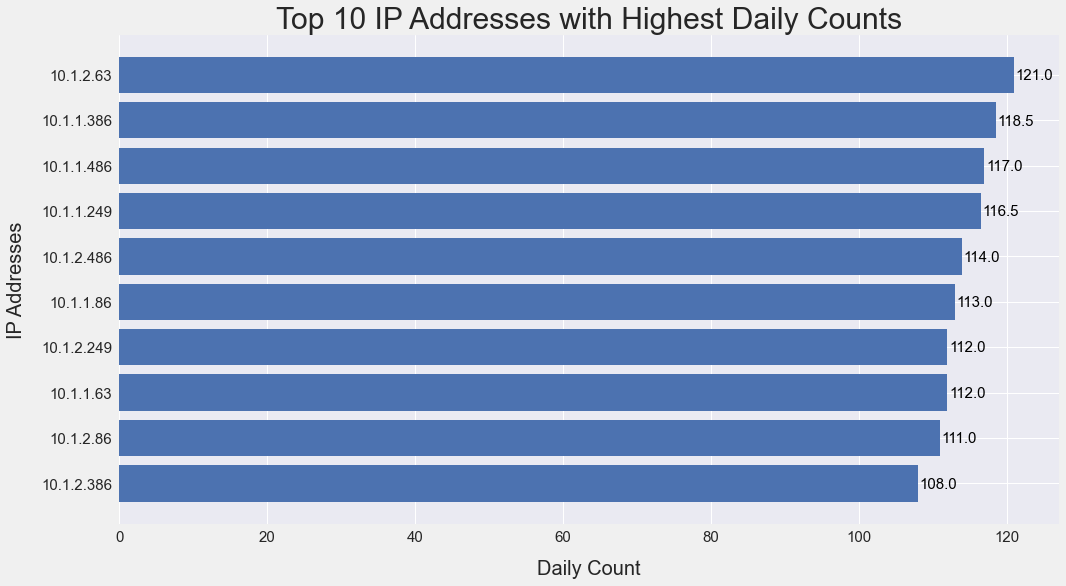

In [221]:
x=daily_counts_agg.sort_values('daily_counts', ascending=False)
x=x.iloc[:10]


lst1=x['ip_address'].to_numpy()
lst2=x['daily_counts'].to_numpy()
#lst2=lst2.astype(int)


fig, ax = plt.subplots(figsize =(15, 9))
 
# Horizontal Bar Plot
ax.barh(lst1, lst2)
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 15,
             color ='black')

ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)
# Add Plot Title
plt.title('Top 10 IP Addresses with Highest Daily Counts', fontdict={'fontsize': 30})
 
# Show Plot
plt.xlabel('Daily Count', fontdict={'fontsize': 20}, labelpad=15)
plt.ylabel('IP Addresses', fontdict={'fontsize': 20}, labelpad=15)

plt.show()

## weekday weekend counts average

In [20]:
weekend_counts = data.groupby([ip_col, 'is_weekend'])['@timestamp'].count().reset_index()

In [21]:
weekend_counts = weekend_counts.rename(columns={'@timestamp':'weekend_counts'})
weekend_counts

,ip_address,is_weekend,weekend_counts
0,10.1.1.1,0,975
1,10.1.1.1,1,471
2,10.1.1.100,0,1960
3,10.1.1.100,1,900
4,10.1.1.101,0,1006
...,...,...,...
767,10.1.2.90,1,871
768,10.1.2.95,0,1973
769,10.1.2.95,1,895
770,10.1.2.99,0,978


In [22]:
weekend_counts_agg = weekend_counts.pivot_table(index=ip_col, columns='is_weekend').reset_index([0])

In [23]:
weekend_counts_agg.columns = weekend_counts_agg.columns.droplevel()

In [24]:
weekend_counts_agg.columns = [ip_col, 'week_day', 'weekend']

In [25]:
weekend_counts_agg['is_weekend_ratio'] = weekend_counts_agg['week_day']/ weekend_counts_agg['weekend']

In [212]:
lean_weekend_counts_agg = weekend_counts_agg[[ip_col, 'is_weekend_ratio']]
lean_weekend_counts_agg

,ip_address,is_weekend_ratio
0,10.1.1.1,2.070064
1,10.1.1.100,2.177778
2,10.1.1.101,2.191721
3,10.1.1.106,2.229358
4,10.1.1.109,2.206593
...,...,...
381,10.1.2.86,2.209389
382,10.1.2.89,2.196833
383,10.1.2.90,2.334099
384,10.1.2.95,2.204469


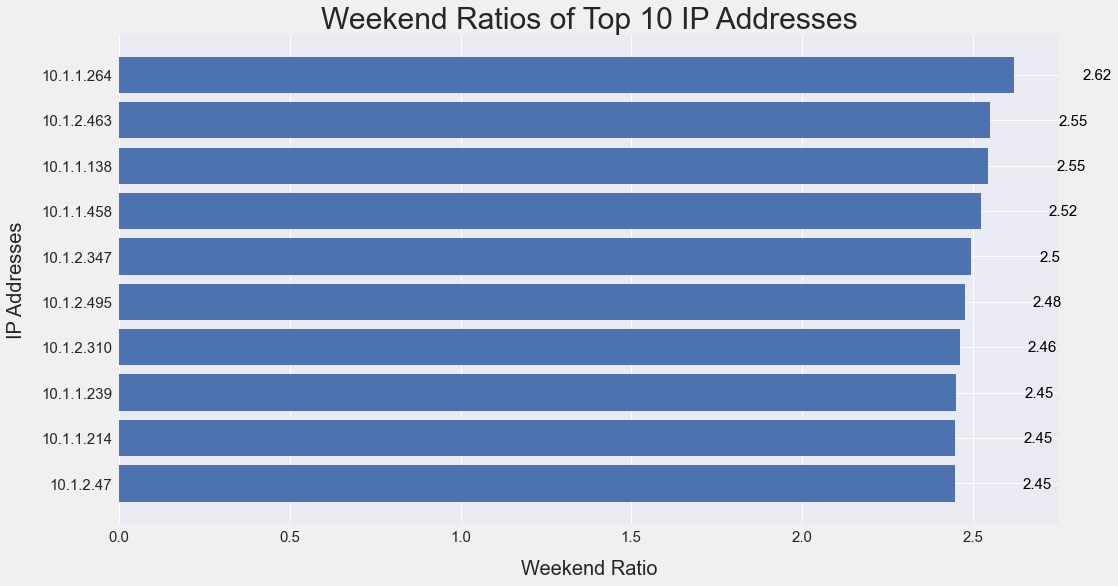

In [220]:
x=lean_weekend_counts_agg.sort_values('is_weekend_ratio', ascending=False)
x=x.iloc[:10]


lst1=x['ip_address'].to_numpy()
lst2=x['is_weekend_ratio'].to_numpy()
#lst2=lst2.astype(int)


fig, ax = plt.subplots(figsize =(15, 9))
 
# Horizontal Bar Plot
ax.barh(lst1, lst2)
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 15,
             color ='black')

ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)
# Add Plot Title
plt.title('Weekend Ratios of Top 10 IP Addresses', fontdict={'fontsize': 30})
 
# Show Plot
plt.xlabel('Weekend Ratio', fontdict={'fontsize': 20}, labelpad=15)
plt.ylabel('IP Addresses', fontdict={'fontsize': 20}, labelpad=15)

plt.show()

## avg login time

In [27]:
avg_timedelta_data = data.groupby(ip_col).agg({'time_diff':['mean','max']}).reset_index()

In [28]:
avg_timedelta_data.columns = avg_timedelta_data.columns.droplevel()

In [29]:
avg_timedelta_data.columns = [ip_col, 'td_mean', 'td_max']

In [30]:
avg_timedelta_data.head(10)

,ip_address,td_mean,td_max
0,10.1.1.1,28.999308,362.0
1,10.1.1.100,14.427072,185.0
2,10.1.1.101,28.520492,211.0
3,10.1.1.106,29.771144,319.0
4,10.1.1.109,28.711934,278.0
5,10.1.1.110,28.249831,240.0
6,10.1.1.114,29.827169,300.0
7,10.1.1.118,28.976471,267.0
8,10.1.1.119,29.087561,232.0
9,10.1.1.12,30.152408,250.0


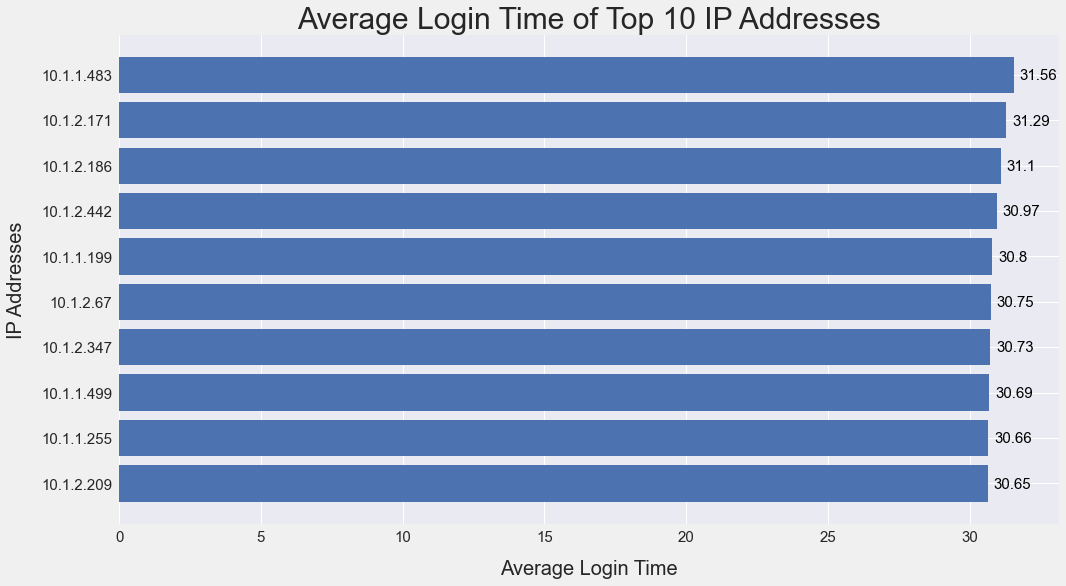

In [219]:
x=avg_timedelta_data.sort_values('td_mean', ascending=False)
x=x.iloc[:10]


lst1=x['ip_address'].to_numpy()
lst2=x['td_mean'].to_numpy()
#lst2=lst2.astype(int)


fig, ax = plt.subplots(figsize =(15, 9))
 
# Horizontal Bar Plot
ax.barh(lst1, lst2)
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 15,
             color ='black')

ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)
# Add Plot Title
plt.title('Average Login Time of Top 10 IP Addresses', fontdict={'fontsize': 30})
 
# Show Plot
plt.xlabel('Average Login Time', fontdict={'fontsize': 20}, labelpad=15)
plt.ylabel('IP Addresses', fontdict={'fontsize': 20}, labelpad=15)

plt.show()

## Full Feature Set

In [31]:
merge_1 = ip_counts.merge(daily_counts_agg, on=ip_col, how='left')

In [32]:
merge_2 = merge_1.merge(lean_weekend_counts_agg, on=ip_col, how='left')

In [33]:
final_data = merge_2.merge(avg_timedelta_data, on=ip_col, how='left')

In [34]:
final_data.head(10)

,ip_address,total_count,daily_counts,is_weekend_ratio,td_mean,td_max
0,10.1.1.1,1446,40.0,2.070064,28.999308,362.0
1,10.1.1.100,2860,78.0,2.177778,14.427072,185.0
2,10.1.1.101,1465,40.0,2.191721,28.520492,211.0
3,10.1.1.106,1408,35.5,2.229358,29.771144,319.0
4,10.1.1.109,1459,42.5,2.206593,28.711934,278.0
5,10.1.1.110,1482,41.0,2.242888,28.249831,240.0
6,10.1.1.114,1407,37.0,2.140625,29.827169,300.0
7,10.1.1.118,1446,42.0,2.308924,28.976471,267.0
8,10.1.1.119,1440,42.0,2.257919,29.087561,232.0
9,10.1.1.12,1392,40.0,2.200000,30.152408,250.0


In [35]:
ip_map = final_data[ip_col].to_dict()

In [36]:
RANDOM_STATE = 123

## KMEANS

In [37]:
final_data.columns

Index(['ip_address', 'total_count', 'daily_counts', 'is_weekend_ratio',
       'td_mean', 'td_max'],
      dtype='object')

In [38]:
feature_cols = ['total_count', 'daily_counts', 'is_weekend_ratio', 'td_mean', 'td_max']

In [39]:
data_new = final_data[feature_cols]

In [40]:
min_max_scaler = preprocessing.MinMaxScaler()

In [41]:
np_scaled = min_max_scaler.fit_transform(data_new)
data_new = pd.DataFrame(np_scaled, columns=feature_cols)

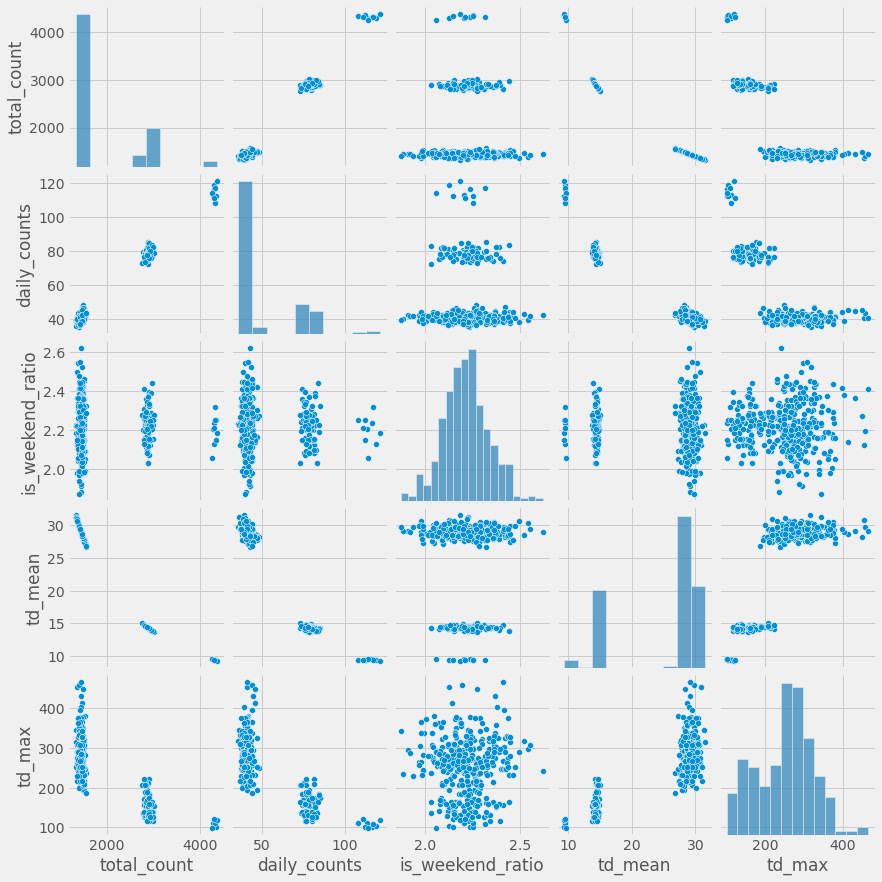

In [42]:
sns.pairplot(final_data[feature_cols])

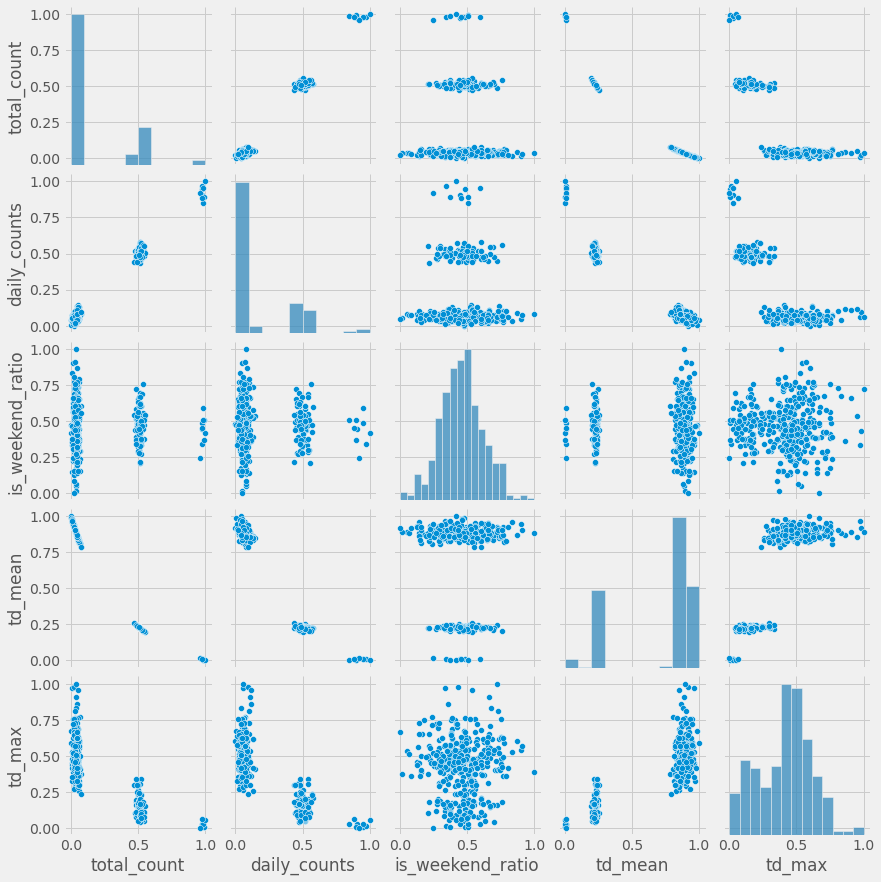

In [43]:
sns.pairplot(data_new)

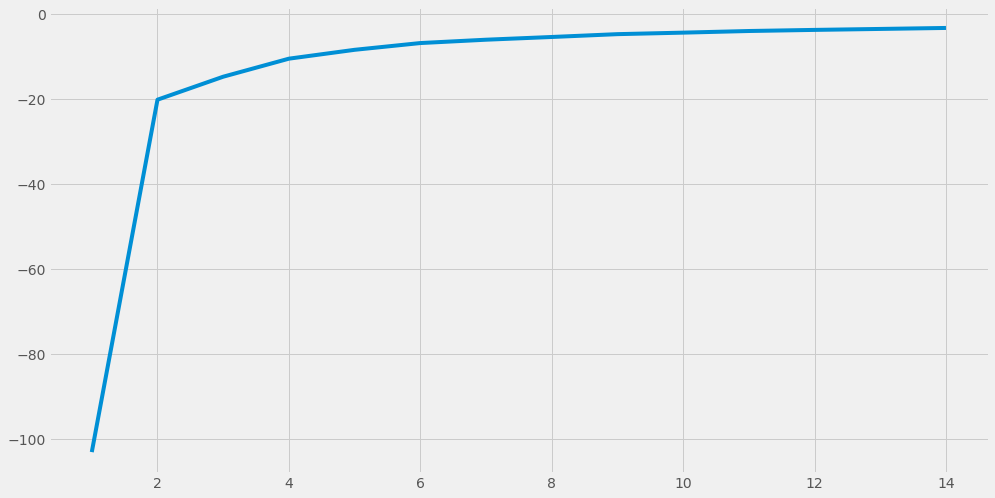

In [44]:
n_cluster = range(1, 15)
kmeans = [KMeans(n_clusters=i, random_state=RANDOM_STATE).fit(data_new) for i in n_cluster]
scores = [kmeans[i].score(data_new) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [45]:
cluster_model = kmeans[5]

In [46]:
final_data['cluster'] = cluster_model.predict(data_new)
final_data['cluster'].value_counts()

5    102
1     94
2     74
4     59
0     47
3     10
Name: cluster, dtype: int64

In [47]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=RANDOM_STATE)

In [48]:
tsne_results = tsne.fit_transform(data_new)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 386 samples in 0.013s...
[t-SNE] Computed neighbors for 386 samples in 0.039s...
[t-SNE] Computed conditional probabilities for sample 386 / 386
[t-SNE] Mean sigma: 0.077309
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.855007
[t-SNE] KL divergence after 300 iterations: 0.309606


In [49]:
final_data['tsne-2d-one'] = tsne_results[:,0]
final_data['tsne-2d-two'] = tsne_results[:,1]

In [50]:
tsne_cluster = final_data.groupby('cluster').agg({'tsne-2d-one':'mean', 'tsne-2d-two':'mean'}).reset_index()

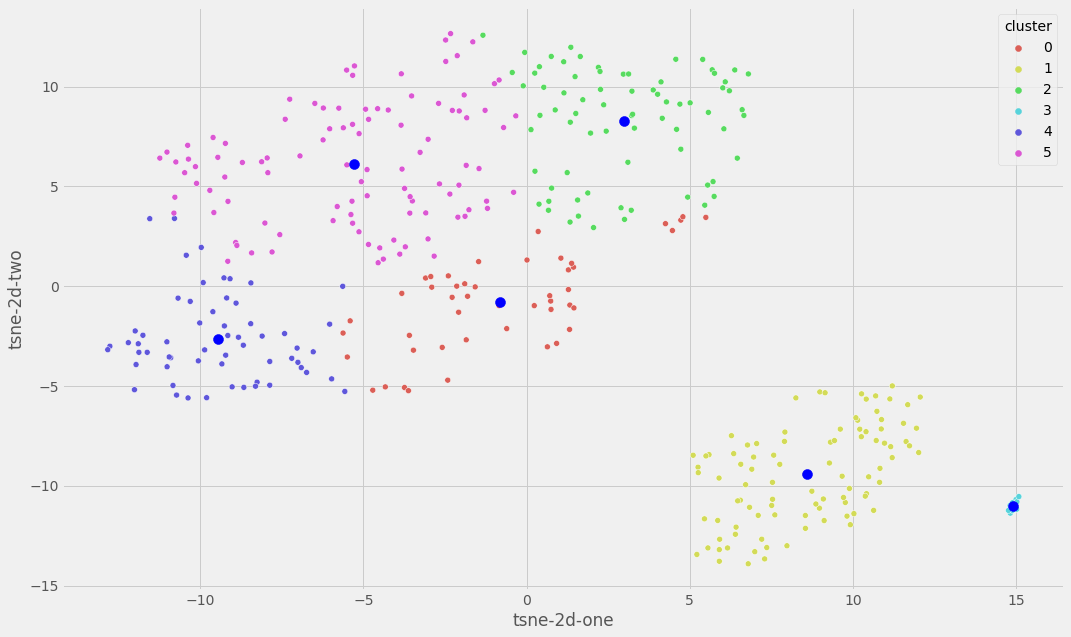

In [51]:
plt.figure(figsize=(16,10))

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="cluster",
    palette=sns.color_palette("hls", 6),
    data=final_data,
    legend="full",
    alpha=1
)

plt.scatter(x="tsne-2d-one", y="tsne-2d-two", data=tsne_cluster, s=100, c='b')

plt.show()

In [52]:
centers = cluster_model.cluster_centers_

In [53]:
points = np.asarray(data_new)

In [54]:
total_distance = pd.Series()

<ipython-input-54-b8bd83b6d12b>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  total_distance = pd.Series()


# Isolated Forests

In [73]:
outlier_fraction = 0.028

In [74]:
final_data.head()

,ip_address,total_count,daily_counts,is_weekend_ratio,td_mean,td_max,cluster,tsne-2d-one,tsne-2d-two
0,10.1.1.1,1446,40.0,2.070064,28.999308,362.0,0,4.728207,3.310586
1,10.1.1.100,2860,78.0,2.177778,14.427072,185.0,1,7.918509,-7.309030
2,10.1.1.101,1465,40.0,2.191721,28.520492,211.0,5,-5.515135,10.829874
3,10.1.1.106,1408,35.5,2.229358,29.771144,319.0,0,-1.895038,0.119527
4,10.1.1.109,1459,42.5,2.206593,28.711934,278.0,5,-3.739272,4.899753


In [75]:
final_data.columns

Index(['ip_address', 'total_count', 'daily_counts', 'is_weekend_ratio',
       'td_mean', 'td_max', 'cluster', 'tsne-2d-one', 'tsne-2d-two'],
      dtype='object')

In [76]:
data_new.head()

,total_count,daily_counts,is_weekend_ratio,td_mean,td_max
0,0.038133,0.052632,0.264803,0.884954,0.716621
1,0.502959,0.497076,0.408397,0.231366,0.234332
2,0.044379,0.052632,0.426985,0.863479,0.305177
3,0.025641,0.000000,0.477159,0.919573,0.599455
4,0.042406,0.081871,0.446812,0.872065,0.487738


In [77]:
model =  IsolationForest(n_jobs=-1, n_estimators=200, max_features=3, random_state=RANDOM_STATE, contamination=outlier_fraction)

In [78]:
model.fit(data_new)

IsolationForest(contamination=0.028, max_features=3, n_estimators=200,
                n_jobs=-1, random_state=123)

In [79]:
# add the data to the main  
final_data['anomaly_isolated'] = pd.Series(model.predict(data_new))

In [80]:
final_data['anomaly_isolated'] = final_data['anomaly_isolated'].map( {1: 0, -1: 1} )

In [81]:
final_data['anomaly_isolated'].value_counts()

0    375
1     11
Name: anomaly_isolated, dtype: int64

In [ ]:
anomalyCount=final_data['anomaly_isolated'].value_counts()

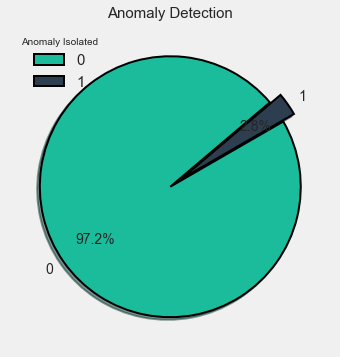

In [280]:
fig, ax = plt.subplots(figsize =(15, 6))
sizes = y
v = np.array(anomalyCount)
labels =  ['0','1']
colors = ["#1abc9c", "#2c3e50"]
explode = [0,0.1]
wedge_properties = {"edgecolor":"k",'linewidth': 2}

plt.pie(v, labels=labels, explode=explode, colors=colors, startangle=30,
           counterclock=False, shadow=True, wedgeprops=wedge_properties,
           autopct="%1.1f%%", pctdistance=0.7, textprops={'fontsize': 14})

plt.title("Anomaly Detection",fontsize=15)
plt.legend(title='Anomaly Isolated',fontsize=15)
plt.show()
 




<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

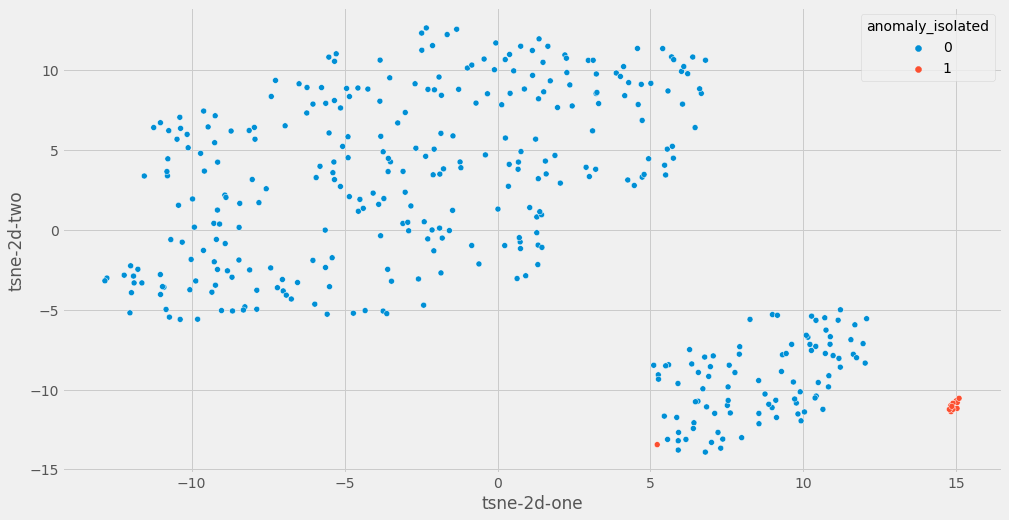

In [82]:
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="anomaly_isolated",
#     palette=sns.color_palette("hls", 10),
    data=final_data,
    legend="full",
    alpha=1
)

In [83]:
final_data.loc[final_data['anomaly_isolated']==1]

,ip_address,total_count,daily_counts,is_weekend_ratio,td_mean,td_max,cluster,tsne-2d-one,tsne-2d-two,anomaly_isolated
62,10.1.1.249,4301,116.5,2.236268,9.459535,101.0,3,15.023369,-11.176354,1
118,10.1.1.386,4300,118.5,2.127273,9.453361,104.0,3,15.001057,-10.694612,1
164,10.1.1.486,4317,117.0,2.315668,9.417285,108.0,3,14.826185,-11.374244,1
177,10.1.1.63,4339,112.0,2.148766,9.368142,101.0,3,15.028952,-10.803132,1
188,10.1.1.86,4293,113.0,2.203731,9.456897,110.0,3,14.819339,-10.991501,1
255,10.1.2.249,4353,112.0,2.250934,9.332721,102.0,3,14.889320,-11.234340,1
311,10.1.2.386,4326,108.0,2.250188,9.392370,110.0,3,14.771705,-11.234375,1
357,10.1.2.486,4251,114.0,2.056075,9.571059,99.0,3,15.089677,-10.543327,1
361,10.1.2.497,2973,83.5,2.440972,13.869785,165.0,1,5.220059,-13.443276,1
370,10.1.2.63,4372,121.0,2.184268,9.268588,118.0,3,14.890451,-10.853577,1


# Performance of Algo

Since it is unsupervised we need to manually label the data and see the performance of the individual algos

- Criteria for manual labels is strictly based on counts as we want the algos to be robust on count anomalies

In [84]:
total_counts_condition = (final_data['total_count'] >= final_data['total_count'].quantile(0.98)) 
daily_counts_condition =  (final_data['daily_counts'] >= final_data['daily_counts'].quantile(0.98))

In [85]:
final_data['anomaly_manual'] = (total_counts_condition | daily_counts_condition).astype(np.int)

In [86]:
final_data.head()

,ip_address,total_count,daily_counts,is_weekend_ratio,td_mean,td_max,cluster,tsne-2d-one,tsne-2d-two,anomaly_isolated,anomaly_manual
0,10.1.1.1,1446,40.0,2.070064,28.999308,362.0,0,4.728207,3.310586,0,0
1,10.1.1.100,2860,78.0,2.177778,14.427072,185.0,1,7.918509,-7.309030,0,0
2,10.1.1.101,1465,40.0,2.191721,28.520492,211.0,5,-5.515135,10.829874,0,0
3,10.1.1.106,1408,35.5,2.229358,29.771144,319.0,0,-1.895038,0.119527,0,0
4,10.1.1.109,1459,42.5,2.206593,28.711934,278.0,5,-3.739272,4.899753,0,0


In [87]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, confusion_matrix

In [88]:
def get_sensitivity_specificity(y_true, y_pred):
    cf = confusion_matrix(y_true, y_pred)
    sensitivity = cf[0,0]/(cf[:,0].sum())
    specificity = cf[1,1]/(cf[:,1].sum())
    return sensitivity, specificity

In [89]:
f1_iso = f1_score(final_data['anomaly_manual'],final_data['anomaly_isolated'])
acc_iso = accuracy_score(final_data['anomaly_manual'],final_data['anomaly_isolated'])
roc_iso = roc_auc_score(final_data['anomaly_manual'],final_data['anomaly_isolated'])
sen_iso, spec_iso = get_sensitivity_specificity(final_data['anomaly_manual'],final_data['anomaly_isolated'])
met_iso = {
           'f1_score': f1_iso,
           'accuracy': acc_iso,
           'roc_score': roc_iso,
           'sensitivity': sen_iso,
           'specificity': spec_iso
          }

In [90]:
metrics = {'isolated_forest': met_iso,
          }

In [91]:
metrics_df = pd.DataFrame.from_dict(metrics)

In [92]:
metrics_df

,isolated_forest
accuracy,0.997409
f1_score,0.952381
roc_score,0.998670
sensitivity,1.000000
specificity,0.909091
